<a href="https://www.kaggle.com/code/oakthyago/photovoltaic-classification-sunny-cloudy-shadow?scriptVersionId=110656076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

A photovoltaic system are made, in resume , of photovoltaic modules getting the sunlight and genarating CC voltage. Apllying this to a power inverter and you can use this energy as every regular house uses. In this process you can find 3 distant situation over the modules:

- plenty of sun
- Clound block
- objects block on some modules ("Photovoltaic Shadowness")

A thin shadon upon a module can affect the genaration of the all roll since we usually increase the voltage of the system by conecting the modules in series. When a shadows goes into one module this affect the whole array set and the power genaration goes down. A good indication of object block can be easily find when one of the arrays power is down over the other.

On this work this will be the objective to cluster all this points and classify them by Sunny/Clondy and Shadow.

# System 1 

![a](https://i.postimg.cc/BnNBJmmz/mybars.gif)

# Sytem 2 - without objects shadow

![a](https://i.postimg.cc/qq98RnXS/boa-2.gif)

# Sytem 3 - without objects shadow

![a](https://i.postimg.cc/MK7DTPNY/d33.gif)

![a](https://i.postimg.cc/8cz5xZny/paulino.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("../input/solarenergynortheastbrazil/2_Paulino_newdata.csv")
df["Single Plate Ambient Temperature"] = df.iloc[:, 38] #the original columns was not working when called by name

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26757 entries, 0 to 26756
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           26757 non-null  int64  
 1   Device Type                          26757 non-null  object 
 2   SN                                   26757 non-null  object 
 3   Parent Device                        26757 non-null  int64  
 4   Time                                 26757 non-null  object 
 5   Hardware Version                     26757 non-null  object 
 6   Master Software Version              26757 non-null  object 
 7   Vice Software Version                26757 non-null  object 
 8   Standard Main Version                26757 non-null  int64  
 9   Communication CPU Software Version   26757 non-null  object 
 10  DC Voltage PV1(V)                    26757 non-null  float64
 11  DC Voltage PV2(V)           

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,Device Type,SN,Parent Device,Time,Hardware Version,Master Software Version,Vice Software Version,Standard Main Version,Communication CPU Software Version,DC Voltage PV1(V),DC Voltage PV2(V),DC Current PV1(A),DC Current PV2(A),DC Power PV1(W),DC Power PV2(W),Total Power Generation(W),AC Voltage R/U/A(V),AC Current R/U/A(A),AC Output Frequency R(Hz),Total AC Output Power(W),Cumulative Production (Active)(kWh),Daily Production (Active)(kWh),Dc Component- Phase R Current(mA),Total Reactive Power(W),Ppc Ac Current R(A),Ppc Ac Power R(W),Grid Status,Total Grid Power(W),Leak Current(mA),Insulation Impedance 1(KΩ),Combiner Voltage-Group 1(V),String Current- Group 1 Line 1(A),String Current- Group 1 Line 2(A),Combiner Voltage-Group 2(V),String Current- Group 2 Line 1(A),String Current- Group 2 Line 2(A),Total Consumption Power(W),Single Plate Ambient Temperature(℃),Radiator Temperature 1(℃),System Time,Generation Time Today(Min),Generation Time Total(Min),Total Running Hour(h),Boot Countdown,Bus Voltage(V),Inverter status,Slave Address,Single Plate Ambient Temperature
0,0,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:16:58,V001,V000000,V000000,0,V030001,0.0,0.0,0.00,0.00,0.0,0.0,0,0.0,0.00,0.00,0.0,116.8,0.0,0,0.0,0.00,0.0,Static,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2022-05-07 05:16:31,0,5943,101.27,0,0.0,Waiting,NaN,0
1,1,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:22:04,V200,V030006,V030001,601,V030001,152.6,152.6,0.41,0.57,60.0,80.0,140,218.8,0.07,60.02,0.0,116.8,0.0,0,0.0,0.41,0.0,Static,0.0,2,0,152.7,0.0,0.0,152.6,0.0,0.0,0.0,36,25,2022-05-07 05:21:44,0,5943,101.35,201,151.2,Waiting,NaN,36
2,2,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:27:08,V200,V030006,V030001,601,V030001,160.2,160.2,0.42,0.56,60.0,90.0,150,222.8,0.08,59.98,0.0,116.8,0.0,0,0.0,0.41,0.0,Static,0.0,3,0,160.2,0.0,0.0,160.2,0.0,0.0,0.0,37,25,2022-05-07 05:26:53,0,5943,101.43,213,158.7,Waiting,NaN,37
3,3,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:32:13,V200,V030006,V030001,601,V030001,132.2,136.3,0.10,0.14,10.0,10.0,20,218.6,0.56,59.96,20.0,116.8,0.0,-1,0.0,0.39,0.0,Static,0.0,5,787,136.2,0.0,0.0,132.2,0.0,0.0,0.0,37,25,2022-05-07 05:32:04,1,5944,101.53,180,349.9,Grid connected,NaN,37
4,4,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:37:19,V200,V030006,V030001,601,V030001,144.2,140.3,0.30,0.33,40.0,40.0,80,224.7,0.20,59.96,30.0,116.8,0.0,-1,0.0,0.38,0.0,Static,0.0,8,787,144.2,0.0,0.0,140.3,0.0,0.0,0.0,38,26,2022-05-07 05:37:13,6,5949,101.62,180,358.8,Grid connected,NaN,38


<AxesSubplot:>

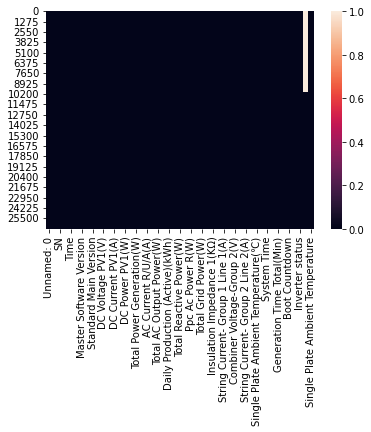

In [5]:
#to see if the dataset has some null values
sns.heatmap(df.isnull())


In [6]:
#sns.pairplot(df)

In [7]:
df['Date'] = df['Time'].apply(lambda x: x.split(' ')[0])
df['Hour'] = df['Time'].apply(lambda x: x.split(' ')[1])
df["Time"] = pd.to_datetime(df["Time"])

In [8]:
calendar_dc = df.pivot_table(values='DC Power PV1(W)', index='Time', columns='Date')

<AxesSubplot:>

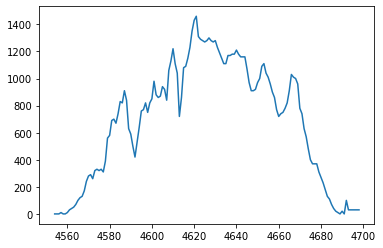

In [9]:
df[df["Date"] == "2022/06/07"]["Total AC Output Power(W)"].plot()

In [10]:
#sns.jointplot(x='Hour', y="Total AC Output Power(W)",data=df2)

In [11]:
corr_matrix=df.corr()
corr_matrix["Total AC Output Power(W)"].sort_values(ascending=False)

Total AC Output Power(W)               1.000000
AC Current R/U/A(A)                    0.999398
DC Power PV1(W)                        0.994282
DC Power PV2(W)                        0.993464
DC Current PV1(A)                      0.991589
DC Current PV2(A)                      0.991576
Ppc Ac Current R(A)                    0.848853
Radiator Temperature 1(℃)              0.761727
Single Plate Ambient Temperature(℃)    0.636220
Single Plate Ambient Temperature       0.636220
AC Voltage R/U/A(V)                    0.323895
Bus Voltage(V)                         0.316159
Combiner Voltage-Group 2(V)            0.268108
DC Voltage PV2(V)                      0.267659
DC Voltage PV1(V)                      0.264907
Combiner Voltage-Group 1(V)            0.264764
AC Output Frequency R(Hz)              0.093956
Standard Main Version                  0.093556
Generation Time Total(Min)             0.078492
Total Running Hour(h)                  0.078487
Unnamed: 0                             0

## Those are the more corelected columns with the power output of the system. It's true that the product of corrent and voltage should be correlected with the power. Its good to resume the dataframe and colect only the columns with some information to work.

Total AC Output Power(W)              
AC Current R/U/A(A)                   
DC Power PV1(W)                       
DC Power PV2(W)                        
DC Current PV1(A)                      
DC Current PV2(A)                     
Ppc Ac Current R(A)                    
Radiator Temperature 1(℃)              
Single Plate Ambient Temperature(℃)    
AC Voltage R/U/A(V)                    
Bus Voltage(V)                        
Combiner Voltage-Group 2(V)            
DC Voltage PV2(V)                      
DC Voltage PV1(V)                      
Combiner Voltage-Group 1(V)            

In [12]:
#here we select this columns
df=df[["Time","Date","Hour","Total AC Output Power(W)","AC Current R/U/A(A)","DC Power PV1(W)","DC Power PV2(W)","DC Current PV1(A)","DC Current PV2(A)","Ppc Ac Current R(A)","Radiator Temperature 1(℃)","Single Plate Ambient Temperature","AC Voltage R/U/A(V)","Bus Voltage(V)","Combiner Voltage-Group 2(V)","DC Voltage PV2(V)","DC Voltage PV1(V)","Combiner Voltage-Group 1(V)"]]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26757 entries, 0 to 26756
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Time                              26757 non-null  datetime64[ns]
 1   Date                              26757 non-null  object        
 2   Hour                              26757 non-null  object        
 3   Total AC Output Power(W)          26757 non-null  float64       
 4   AC Current R/U/A(A)               26757 non-null  float64       
 5   DC Power PV1(W)                   26757 non-null  float64       
 6   DC Power PV2(W)                   26757 non-null  float64       
 7   DC Current PV1(A)                 26757 non-null  float64       
 8   DC Current PV2(A)                 26757 non-null  float64       
 9   Ppc Ac Current R(A)               26757 non-null  float64       
 10  Radiator Temperature 1(℃)         26757 non-nu

Its necessáry to round the time in 5 to 5 minutes samples and get the mean if there is two or more sample in the same time

In [14]:
df["Time2"] = pd.Series(df["Time"]).dt.round(freq='5T')
df["Hour"] = df.Time2.dt.time #
df["Hour_srt"] = df["Hour"].astype(str) 





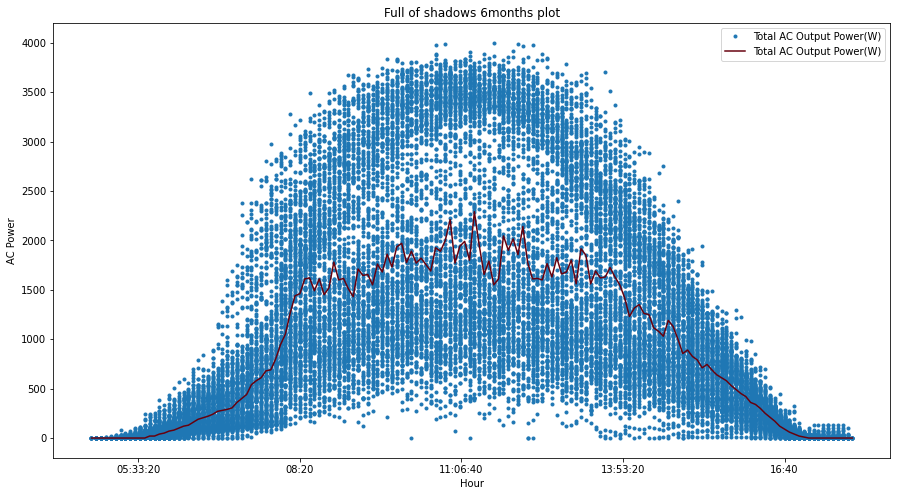

In [15]:
#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df.plot(x= 'Hour', y='Total AC Output Power(W)', style='.', figsize = (15, 8))
df.groupby('Hour')['Total AC Output Power(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Power')
plt.title('Full of shadows 6months plot')
plt.show()

Lets comper it with a cleaning shadows system

In [16]:
df2 = pd.read_csv("../input/solarenergynortheastbrazil/2_Sevem_Marcelo_new_data.csv")


df2["Single Plate Ambient Temperature"] = df2.iloc[:, 38] #the original columns was not working when called by name
df2['Date'] = df2['Time'].apply(lambda x: x.split(' ')[0])
df2['Hour'] = df2['Time'].apply(lambda x: x.split(' ')[1])
df2["Time"] = pd.to_datetime(df2["Time"])
df2=df2[["Time","Date","Hour","Total AC Output Power(W)","AC Current R/U/A(A)","DC Power PV1(W)","DC Power PV2(W)","DC Current PV1(A)","DC Current PV2(A)","Ppc Ac Current R(A)","Radiator Temperature 1(℃)","Single Plate Ambient Temperature","AC Voltage R/U/A(V)","Bus Voltage(V)","Combiner Voltage-Group 2(V)","DC Voltage PV2(V)","DC Voltage PV1(V)","Combiner Voltage-Group 1(V)"]]
df2["Time2"] = pd.Series(df2["Time"]).dt.round(freq='5T')
df2["Hour"] = df2.Time2.dt.time #
df2["Hour_srt"] = df2["Hour"].astype(str) 
df2["Hour_srt"].value_counts()






07:50:00    92
17:00:00    90
08:05:00    90
10:50:00    90
10:55:00    90
            ..
17:45:00    36
04:55:00    29
04:50:00    25
17:50:00    14
04:45:00     8
Name: Hour_srt, Length: 158, dtype: int64

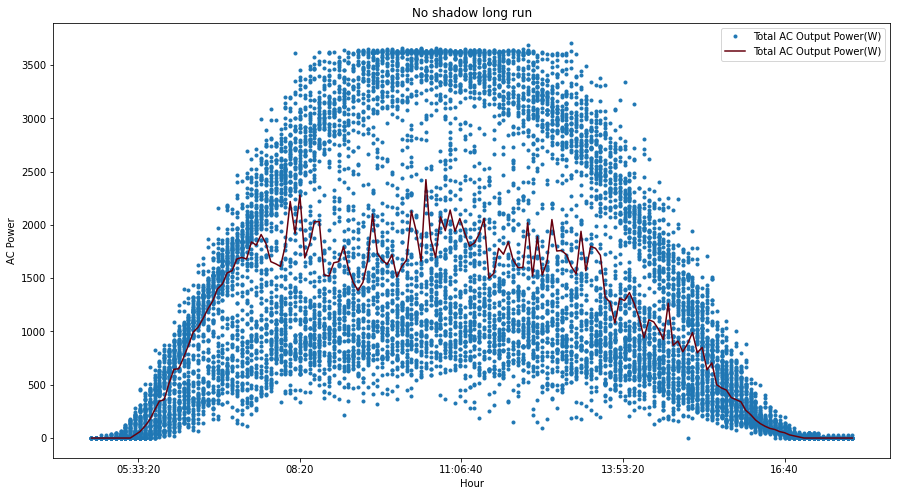

In [17]:
#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df2.plot(x= 'Hour', y='Total AC Output Power(W)', style='.', figsize = (15, 8))
df2.groupby('Hour')['Total AC Output Power(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Power')
plt.title('No shadow long run')
plt.show()

# Comparing 

- The second graphic shows that a upcut on the power close to 3,6kW even though the inverter output is 5kW

- the first graphic is a full of shadow system and the second is not we can notice more definitives values on the not shadow system.

## Problem

- find the reason why the df2 solar system is topping his power upside once the power of the modules are fewer the the inverter AC output power.

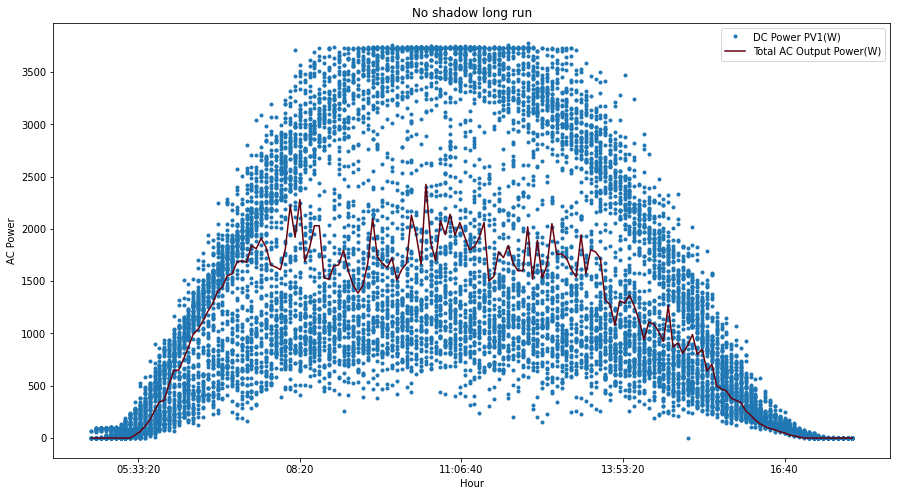

In [18]:
#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df2.plot(x= 'Hour', y='DC Power PV1(W)', style='.', figsize = (15, 8))
df2.groupby('Hour')['Total AC Output Power(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Power')
plt.title('No shadow long run')
plt.show()

In [19]:
df2["DC Power PV1(W)"].max()

3780.0

In [20]:
df2['Total AC Output Power(W)'].max()

3710.0

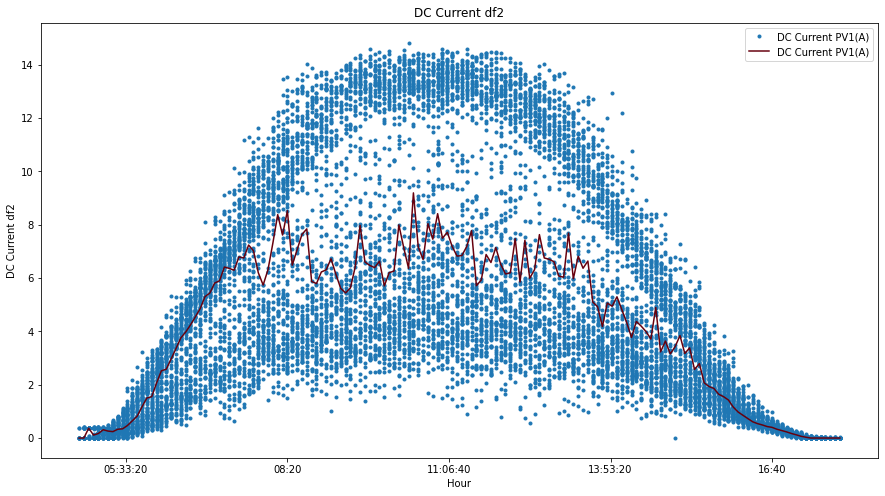

In [21]:


#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df2.plot(x= 'Hour', y='DC Current PV1(A)', style='.', figsize = (15, 8))
df2.groupby('Hour')['DC Current PV1(A)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('DC Current df2')
plt.title('DC Current df2')
plt.show()



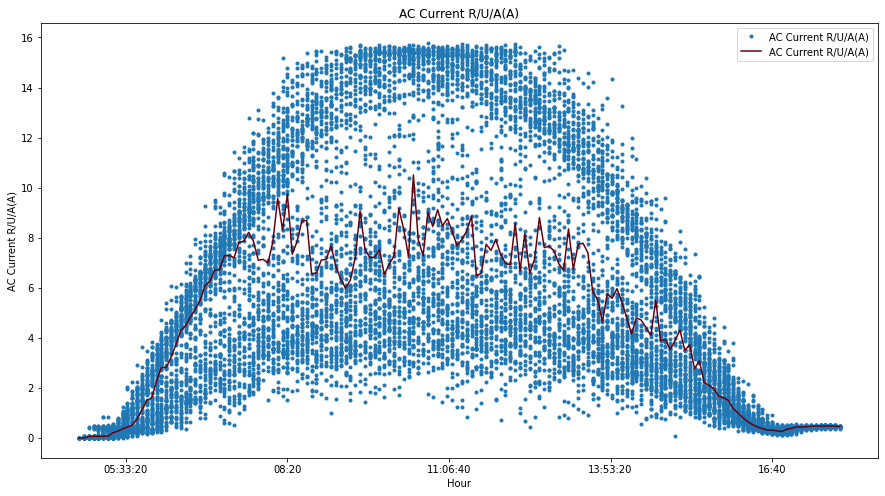

15.79

In [22]:


#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df2.plot(x= 'Hour', y='AC Current R/U/A(A)', style='.', figsize = (15, 8))
df2.groupby('Hour')['AC Current R/U/A(A)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Current R/U/A(A)')
plt.title('AC Current R/U/A(A)')
plt.show()
df2["AC Current R/U/A(A)"].max()

![a](https://i.postimg.cc/Y9ggbYsb/sofar-5k-G3.png)

#AC current is topping on df2

In [23]:
df3 = pd.read_csv("../input/solarenergynortheastbrazil/2_Lindalva_new_data.csv")


df3["Single Plate Ambient Temperature"] = df3.iloc[:, 38] #the original columns was not working when called by name
df3['Date'] = df3['Time'].apply(lambda x: x.split(' ')[0])
df3['Hour'] = df3['Time'].apply(lambda x: x.split(' ')[1])
df3["Time"] = pd.to_datetime(df3["Time"])
df3["Time2"] = pd.Series(df3["Time"]).dt.round(freq='5T')
df3["Hour"] = df3.Time2.dt.time #
df3["Hour_srt"] = df3["Hour"].astype(str) 






In [24]:

df4 = pd.read_csv("../input/solarenergynortheastbrazil/2_Tubarao_new_data.csv")


df4["Single Plate Ambient Temperature"] = df4.iloc[:, 38] #the original columns was not working when called by name
df4['Date'] = df4['Time'].apply(lambda x: x.split(' ')[0])
df4['Hour'] = df4['Time'].apply(lambda x: x.split(' ')[1])
df4["Time"] = pd.to_datetime(df4["Time"])
#df4=df4[["Time","Date","Hour","Total AC Output Power(W)","AC Current R/U/A(A)","DC Power PV1(W)","DC Power PV2(W)","DC Current PV1(A)","DC Current PV2(A)","Ppc Ac Current R(A)","Radiator Temperature 1(℃)","Single Plate Ambient Temperature","AC Voltage R/U/A(V)","Bus Voltage(V)","Combiner Voltage-Group 2(V)","DC Voltage PV2(V)","DC Voltage PV1(V)","Combiner Voltage-Group 1(V)"]]
df4["Time2"] = pd.Series(df4["Time"]).dt.round(freq='5T')
df4["Hour"] = df4.Time2.dt.time #
df4["Hour_srt"] = df4["Hour"].astype(str) 
df4["Hour"].value_counts()

13:50:00    47
16:50:00    47
16:55:00    46
14:00:00    46
13:55:00    46
            ..
04:55:00    36
04:50:00    28
17:40:00    26
04:45:00    12
17:45:00     1
Name: Hour, Length: 157, dtype: int64

In [25]:
corr_matrix2=df3.corr()
corr_matrix2["Total AC Output Power (Active)(W)"].sort_values(ascending=False)

Total AC Output Power (Active)(W)              1.000000
AC Current R/U/A(A)                            0.999807
DC Power PV1(W)                                0.995602
DC Current PV1(A)                              0.994238
DC Power PV2(W)                                0.993809
DC Current PV2(A)                              0.987645
Module temperature1(℃)                         0.746306
Temperature- Inverter(℃)                       0.717312
AC Voltage R/U/A(V)                            0.472028
Back-up CPU Input Current Sample 1             0.467017
DC Voltage PV2(V)                              0.466910
Bus Voltage(V)                                 0.427065
Back-up CPU Input Voltage Sample 1             0.311300
DC Voltage PV1(V)                              0.311136
Countdown Time(s)                              0.155206
CT1-Current A(A)                               0.096917
Single Plate Ambient Temperature               0.096917
Leak Current(mA)                               0

In [26]:
corr_matrix3=df4.corr()
corr_matrix3["Total AC Output Power (Active)(W)"].sort_values(ascending=False)

Total AC Output Power (Active)(W)              1.000000
AC Current R/U/A(A)                            0.999684
DC Power PV1(W)                                0.983768
DC Current PV1(A)                              0.977804
DC Power PV2(W)                                0.975405
DC Current PV2(A)                              0.969553
Module temperature1(℃)                         0.718201
Temperature- Inverter(℃)                       0.690810
AC Voltage R/U/A(V)                            0.643366
Bus Voltage(V)                                 0.471975
Back-up CPU Input Current Sample 1             0.414726
DC Voltage PV2(V)                              0.414467
CT1-Current A(A)                               0.354307
Single Plate Ambient Temperature               0.354307
DC Voltage PV1(V)                              0.231180
Back-up CPU Input Voltage Sample 1             0.231158
Countdown Time(s)                              0.154433
DC Component- Phase A                          0

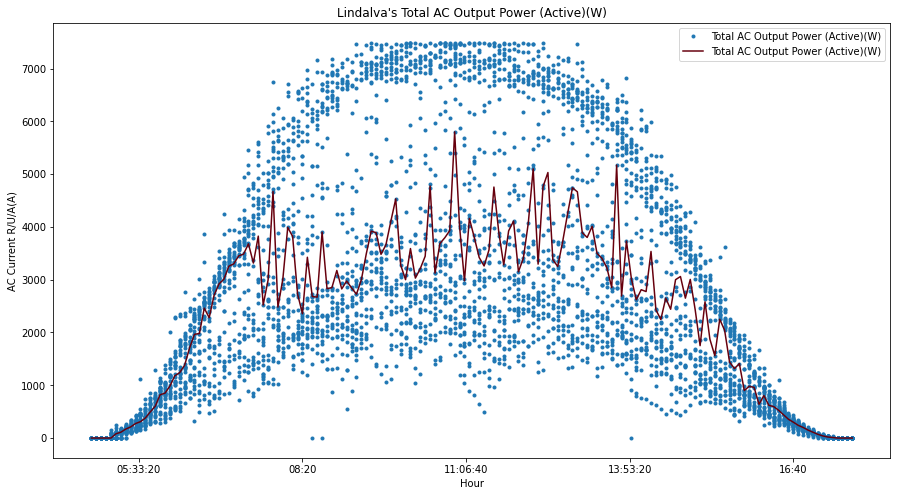

7490

In [27]:

#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df3.plot(x= 'Hour', y='Total AC Output Power (Active)(W)', style='.', figsize = (15, 8))
df3.groupby('Hour')['Total AC Output Power (Active)(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Current R/U/A(A)')
plt.title('Lindalva\'s Total AC Output Power (Active)(W)')
plt.show()
df3["Total AC Output Power (Active)(W)"].max()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:711: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


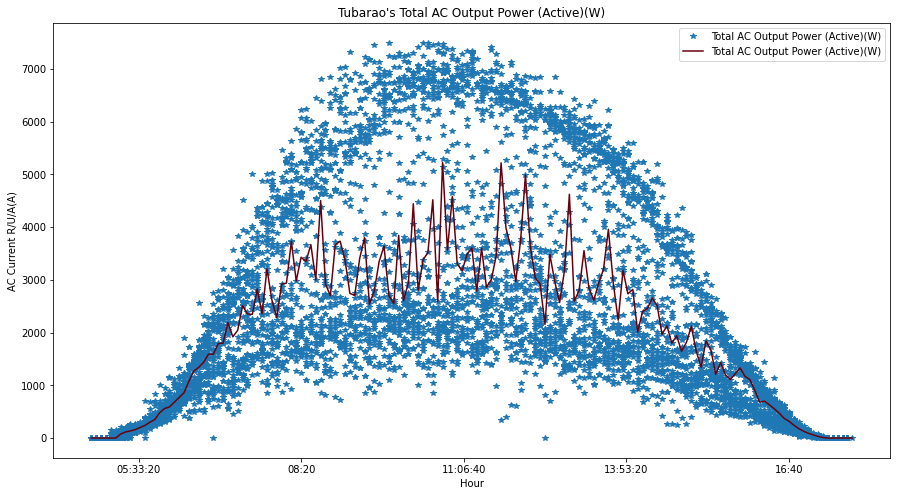

7500

In [28]:

#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df4.plot(x= 'Hour', y='Total AC Output Power (Active)(W)', style='.', figsize = (15, 8),marker='*')
df4.groupby('Hour')['Total AC Output Power (Active)(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Current R/U/A(A)')
plt.title('Tubarao\'s Total AC Output Power (Active)(W)')
plt.show()
plt.style.use("fivethirtyeight")
df4["Total AC Output Power (Active)(W)"].max()

 #### df3 and df4 as the same hardware. 8.1kW of modules and 7.5kW of the inverter.

df3 and df4 system has his topping power limites based on the inverter power limit of 7.5kW and they seem to be working fine. Its easy to see the the insolation in df3 is better than the insolation in df4 because in the peak hour ( the moment where the sun is stronger) df3 is getting more often close to the inverter maximum power. 

# Next steps...

#### Now that was possible to look around the data and get information from all the system its clear by the grafics that a photovoltaic system who as a lot of shadows over the modules its time to use machine learning to cluster:
- Sunny generation
- Objects around Shadow generation
- Cloudy genaration

#### a machine able to categorizes those 3 condition is fundamental to analyse a photovoltaic solar system and this will be achieve by analysing the power output and the 3 temperatures that we have acess on this data frame:

- Module temperature1(℃)
- Temperature- Inverter(℃)
- Single Plate Ambient Temperature  
etc...

those should be the head variables to induce the clustering that we are looking for. On this analysis we notice that  the system df are the one whos the output power is more heterogeneus, in other words, a system full of around objects shadows assumes a lagger rate of power output values.


In [29]:
# special thanks to datacamp - introduction-to-data-science-in-python- free week
# showing that knowledge matters
df_select = df[df.Date > "2022/11/01" ]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:711: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


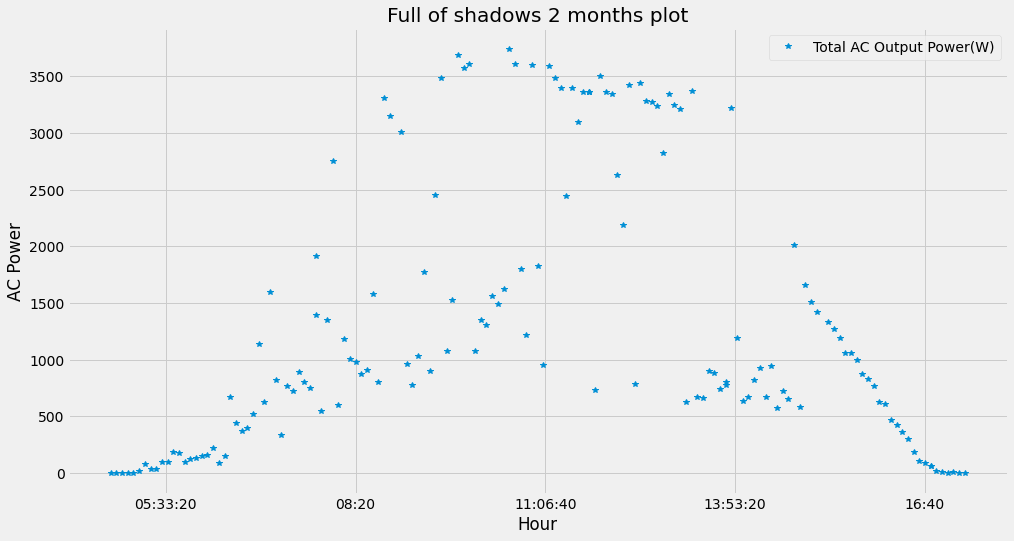

154

In [30]:
#plant1_data.iplot(x= 'time', y='DC_POWER', xTitle='Time',  yTitle= 'DC Power', title='DC POWER plot')
df_select.plot(x= 'Hour', y='Total AC Output Power(W)', style='.', figsize = (15, 8),marker="*")
#df_select.groupby('Hour')['Total AC Output Power(W)'].agg('median').plot(legend=True, colormap='Reds_r')
plt.ylabel('AC Power')
plt.title('Full of shadows 2 months plot')
plt.show()
plt.style.use("seaborn")
len(df_select.Time)

# make the gif of the system



In [31]:
""""
from datetime import datetime
from dateutil.relativedelta import relativedelta


given_date = df4["Date"][0]
totalfiles = len(df4["Date"].value_counts())
file_name = "Paulino"
filenames = []
n=1
date_format = '%Y/%m/%d'

dtObj = datetime.strptime(given_date, date_format)
 for n in range(totalfiles):
    fig = plt.figure()
    future_date = dtObj + relativedelta(days=n)
    x=future_date.strftime("%m")
    y=future_date.strftime("%d")
    string =  '2022'+"/"+ x +"/"+ y

    df_select = df4[df4.Date < string ]
    df_select.plot(x= 'Hour', y='Total AC Output Power (Active)(W)', style='.', figsize = (15, 8),marker="*")
    #df_select.groupby('Hour')['Total AC Output Power(W)'].agg('median').plot(legend=True, colormap='Reds_r')
    plt.ylabel('AC Power')
    plt.title(f'No Shadow\'s System {string}  ')

    plt.style.use('fivethirtyeight')
    

    filename= f'{x}{y}_2022'
   
    plt.savefig(filename,bbox_inches='tight')
    filenames.append(filename)
    plt.show() */
    """           

'"\nfrom datetime import datetime\nfrom dateutil.relativedelta import relativedelta\n\n\ngiven_date = df4["Date"][0]\ntotalfiles = len(df4["Date"].value_counts())\nfile_name = "Paulino"\nfilenames = []\nn=1\ndate_format = \'%Y/%m/%d\'\n\ndtObj = datetime.strptime(given_date, date_format)\n for n in range(totalfiles):\n    fig = plt.figure()\n    future_date = dtObj + relativedelta(days=n)\n    x=future_date.strftime("%m")\n    y=future_date.strftime("%d")\n    string =  \'2022\'+"/"+ x +"/"+ y\n\n    df_select = df4[df4.Date < string ]\n    df_select.plot(x= \'Hour\', y=\'Total AC Output Power (Active)(W)\', style=\'.\', figsize = (15, 8),marker="*")\n    #df_select.groupby(\'Hour\')[\'Total AC Output Power(W)\'].agg(\'median\').plot(legend=True, colormap=\'Reds_r\')\n    plt.ylabel(\'AC Power\')\n    plt.title(f\'No Shadow\'s System {string}  \')\n\n    plt.style.use(\'fivethirtyeight\')\n    \n\n    filename= f\'{x}{y}_2022\'\n   \n    plt.savefig(filename,bbox_inches=\'tight\')\n   

In [32]:
""" import imageio
# Build GIF
print('Creating gif\n')
with imageio.get_writer('d43.gif', mode='I',fps=3) as writer:
    for filename in filenames:
        image = imageio.imread(f'{filename}.png')
        
        writer.append_data(image)
print('Gif saved\n')
"""

" import imageio\n# Build GIF\nprint('Creating gif\n')\nwith imageio.get_writer('d43.gif', mode='I',fps=3) as writer:\n    for filename in filenames:\n        image = imageio.imread(f'{filename}.png')\n        \n        writer.append_data(image)\nprint('Gif saved\n')\n"

In [33]:
""" #removing imgs
import os
for filename in set(filenames):
    os.remove(f'{filename}.png')
print('done') """

" #removing imgs\nimport os\nfor filename in set(filenames):\n    os.remove(f'{filename}.png')\nprint('done') "

![a](https://i.postimg.cc/BnNBJmmz/mybars.gif)